In [1]:
# #installs
# !pip install itables
# !pip install missingno

In [17]:
#Import Libraries
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as pyplot
import seaborn as sns
from itables import show
import itables.options as opt
import missingno as msno
import warnings
opt.warn_on_int_to_str_conversion = False
warnings.filterwarnings('ignore')


In [18]:
# Load Twitter data
df = pd.read_csv('./data/Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv', low_memory=False)

In [19]:
# Check data dimensions
print('Rows: ', df.shape[0])
print('Columns: ', df.shape[1])

Rows:  8529
Columns:  147


In [20]:
# Examine first two observations
show(df.head(2))

## Data Cleaning

### Drop Columns

The plan is to drop columns in which atleast 80% of the data are null values.

These columns cannot be used in the analysis

In [62]:
# Return columns where null values are >= 80%
null_columns = list(df.columns[df.isnull().sum() >= 0.8*len(df)])

In [42]:
# Get the columns that are not completely null
not_null_columns = df.columns[~df.columns.isin(null_columns)]

# Create a new dataframe with only the non-null columns
df_not_null = df[not_null_columns]

In [43]:
# Check new dataframe dimensions
print('Rows: ', df_not_null.shape[0])
print('Columns: ', df_not_null.shape[1])

Rows:  8529
Columns:  34


In [24]:
# Examine first two observations
show(df_not_null.head(2))

### Quality Issues 

The plan is to examine the data for
* duplicates
* wrong data types
* inconsistent / wrong formatting and
* missing data

In [25]:
# Check duplicates
print('Number of duplicates: ', df_not_null.duplicated().sum())

Number of duplicates:  0


In [26]:
# Examine datatypes
show(df_not_null.dtypes)

In [27]:
# Check missing values
show(df_not_null.isnull().sum())

#### List of Quality Issues

* 'Engagement Rate (per Impression)' & 'Click-Through Rate' columns have % sign values
* **16** columns have the wrong datatype
* Several columns have values are formatted with ',' e.g. '200,000'. This format cannot be converted to numeric without issues.
* Several columns have missing values

##### Fix issues with Engagement Rate (per impression) and 'click-through rate formatting'

In [44]:
# Remove % sign from 'Engagement Rate (per Impression)', 'Click-Through Rate' columns
df_not_null['Engagement Rate (per Impression)'] = df_not_null['Engagement Rate (per Impression)'].str.replace('%', '')
df_not_null['Click-Through Rate'] = df_not_null['Click-Through Rate'].str.replace('%', '')

In [47]:
# Confirm changes
df_not_null[['Engagement Rate (per Impression)', 'Click-Through Rate']].head()

,Engagement Rate (per Impression),Click-Through Rate
0,3.6,NaN
1,1.76,NaN
2,4.24,0.82
3,3.4,NaN
4,1.52,NaN


##### Fix issues with wrong data types

In [29]:
# convert "Date" column to datetime
df_not_null['Date'] = pd.to_datetime(df_not_null['Date'])

In [30]:
# Columns to be converted to numeric
numeric_columns = ['Impressions', 'Organic Impressions', 'Potential Reach',
                    'Engagement Rate (per Impression)', 'Engagements', 'Reactions',
                    'Likes', 'Shares', 'Click-Through Rate', 'Other Post Clicks',
                    'Post Clicks (All)', 'Post Media Clicks', 'Post Detail Expand Clicks',
                    'Other Engagements', 'Media Views']

In [51]:
# Convert columns to numeric data type
df_not_null[numeric_columns] = df_not_null[numeric_columns].applymap(lambda x: float(str(x).replace(',', '')))

In [54]:
# Check changes to columns
show(df_not_null[numeric_columns].head(2))

In [53]:
# Examine datatypes
show(df_not_null.dtypes)

In [9]:
# Check missing values
show(df_not_null.isnull().sum())

### Missing data heatmap

<i>"The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:"</i> [Missingno heatmap](https://github.com/ResidentMario/missingno#heatmap)

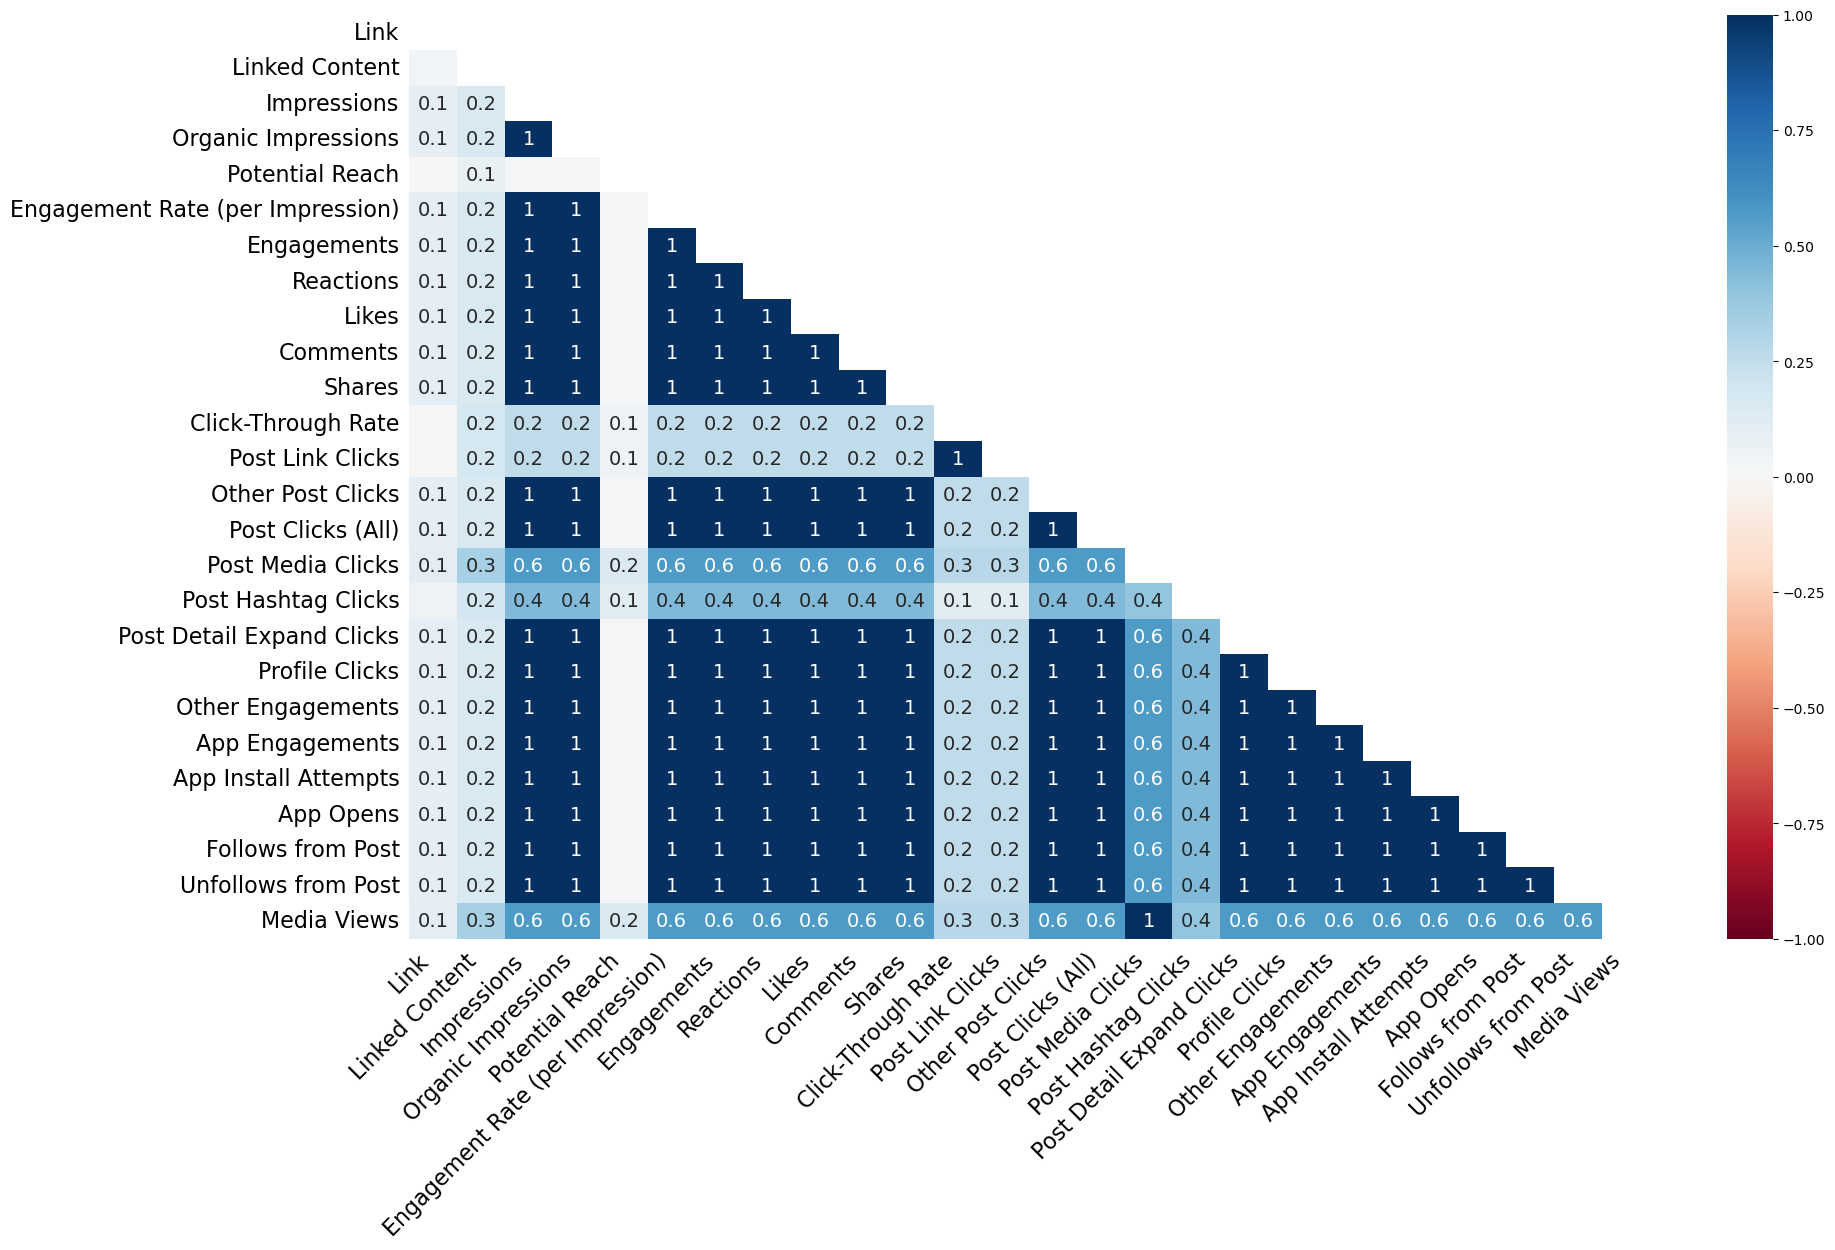

In [10]:
# Create a missing data heatmap
msno.heatmap(df_not_null);

In [58]:
# Check rows where impressions is null
show(df_not_null[df_not_null['Impressions'].isnull()].head())

#### Note:

On careful examination, posts with no impressions correspond to deleted tweets. <br>
This also extends to other columns with a correlation score of 1 in the above heatmap<br> 
The observations will be dropped. 

In [12]:
# Drop rows where impressions are NaN or 0
df_not_null = df_not_null[(df_not_null['Impressions'].notna()) & (df_not_null['Impressions'] != 0)]

In [13]:
# Check missing values
show(df_not_null.isna().sum())

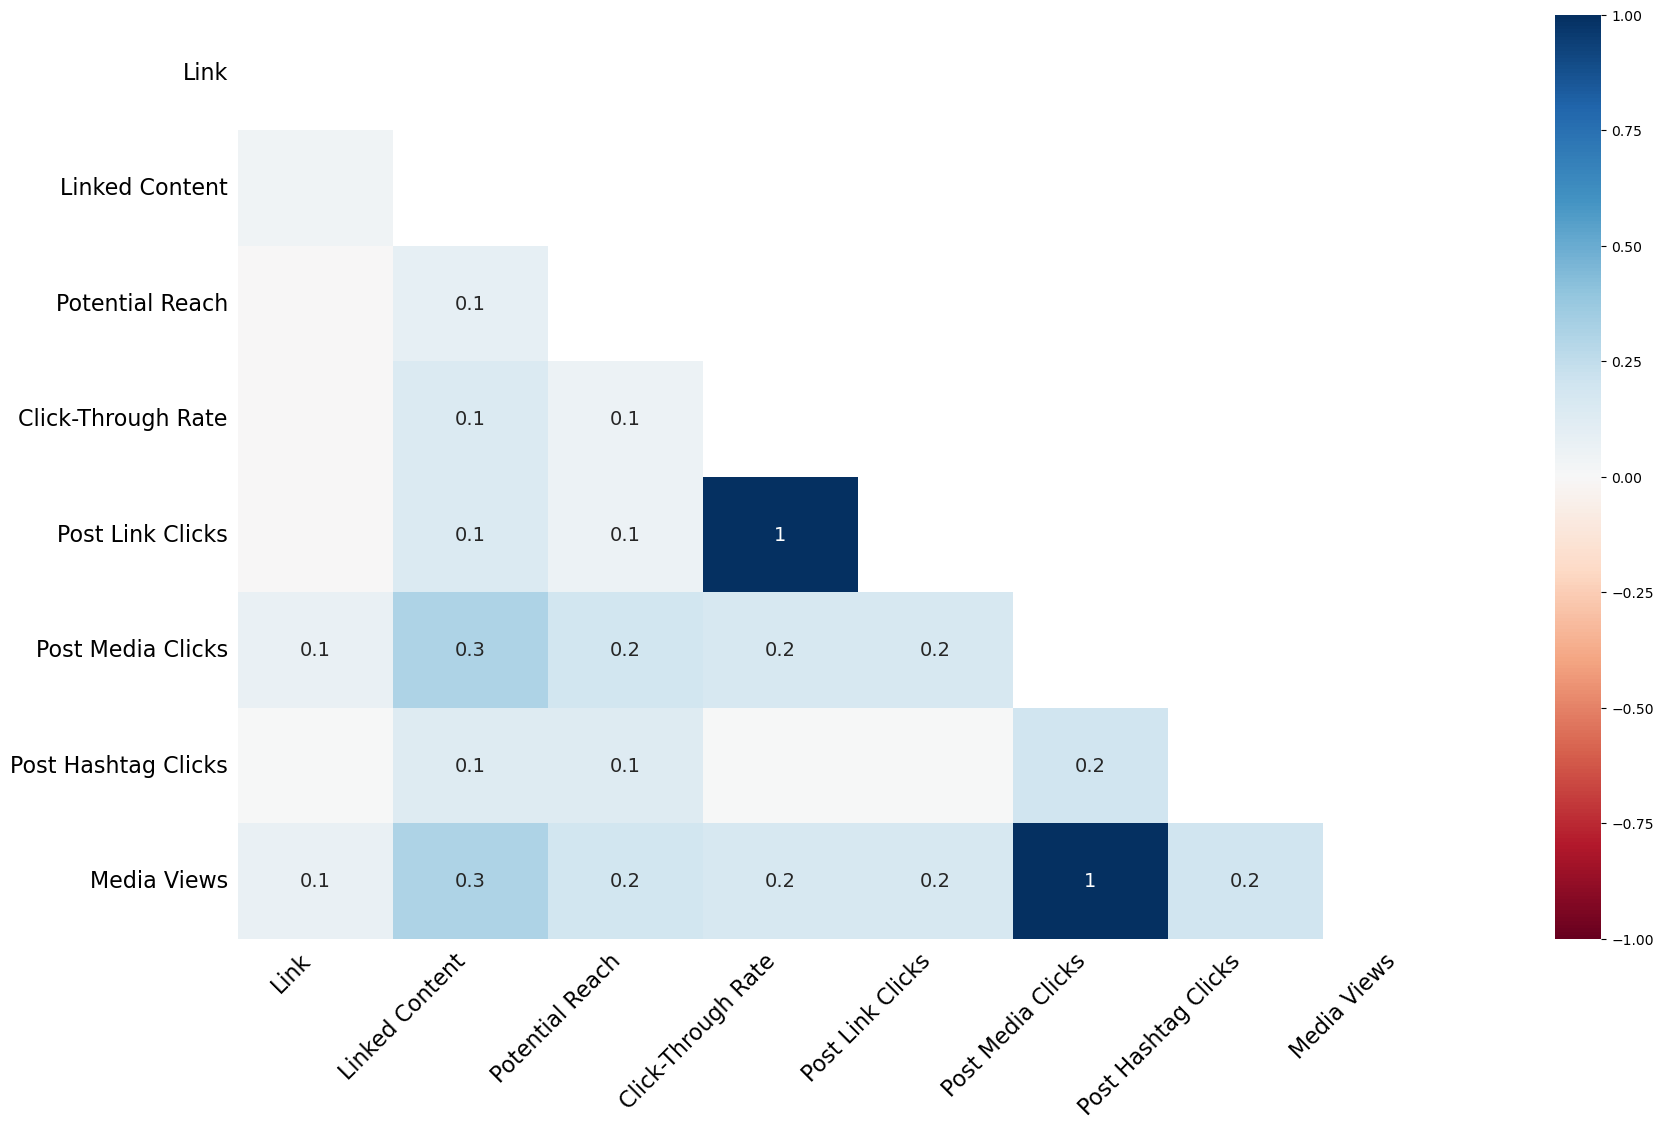

In [14]:
# Check updated missing data heatmap
msno.heatmap(df_not_null);

#### Note:

As seen above, every "Post Link Click" is associated with the Click-Through Rate (CTR)
$$CTR = \frac{Post Link Clicks}{Impressions} \times 100\%$$

From Twitter's glossary, *"Post Link Clicks" is the number of times people clicked on the links in tweets published by an account during the time frame.*

On further examination, observations with null "Post Link Clicks" correspond to posts without links.



In [20]:
# Return "Post Link Clicks" and "Click-Through Rate" columns
show(df_not_null[~df_not_null['Post Link Clicks'].isna()])

In [66]:
show(df_not_null[df_not_null['Linked Content'].isna()][['Post']])

In [107]:
filtered_df = df_not_null[(
     ((df_not_null['Post'].str.contains('https'))
    & (df_not_null['Post'].str.find('https') > df_not_null['Post'].str.find('#')))
    | (~df_not_null['Post'].str.contains('https'))
    )][['Post', 'Post Link Clicks', 'Click-Through Rate']]

In [113]:
show(filtered_df[~filtered_df['Post Link Clicks'].isna()])

In [77]:
# Return dataframe where post contains a link before any hashtags

# filter the dataframe
filtered_df = df_not_null[df_not_null['Post'].str.contains('https') & (df_not_null['Post'].str.find('https') < df_not_null['Post'].str.find('#'))]

# show the filtered dataframe
show(filtered_df)


---

In [142]:
# Check posts without hashtags & missing hashtag clicks
show((df_not_null[
    (~df_not_null['Post'].str.contains('#\w+'))
    & (df_not_null['Post Hashtag Clicks'].isna())
])[['Post','Post Hashtag Clicks']])


#### Note

Posts with missing 'Post HashTag Clicks' do not have hashtags

Posts with missing 'Media Views' and 

This values will be imputed with 0

---

In [137]:
# Check tweets without media content
df_not_null[df_not_null['Media Views'].isna()]['Content Type'].value_counts()

Text    869
Link    275
Name: Content Type, dtype: int64

In [151]:
show(df_not_null.isna().sum())

In [52]:
show(df_not_null[df_not_null['Post Link Clicks'].isna()][['Engagements', 'Impressions','Post Link Clicks', 'Click-Through Rate']])

In [55]:
show(df_not_null[df_not_null['Post Link Clicks'].isna()][['Link', 'Engagements', 'Impressions','Post Link Clicks', 'Click-Through Rate']])

In [59]:
df_not_null[df_not_null['Post Link Clicks'] == 0].shape

(190, 34)

----

In [152]:
df_not_null['Potential Reach'].hist();

<AxesSubplot:>

Error in callback <function flush_figures at 0x0000016C82D3EB80> (for post_execute):


KeyboardInterrupt: 

#### Additional columns to be dropped

* **Post ID**: There is no reason to track individual posts in this analysis.
* **Network, "Post Type"**: Redundant Information
* **Link, "Linked Content"**: The actual links to tweets are not needed for analysis
* **"Organic Impressions"**: The "Organic Impressions" column has the same data as the Impressions column
* **"App Engagements", "App Install Attempts", "App Opens"**: These columns are predominantly filled with 0.

In [150]:
df_not_null['Unfollows from Post'].value_counts()

0.0    7663
1.0     166
2.0      11
3.0       1
Name: Unfollows from Post, dtype: int64